# Data generation and fitting

### Fitting algorithm

In [1]:
# Requires pip install pybigtools
from time import monotonic
import cProfile
from typing import Any
import argparse
import sys
import numpy as np
import scipy.optimize
import math
import os
import time
import pybigtools

def fitfunction(list, v0, st0, fit_step, maxiter, err_threshold, saveQ, info):
    
    timel = list
    
    v = v0
    st = st0
    exp_v = np.exp(-1/v)
    x00 = np.array([(math.pi/(4*v))*i**(-2) for i in timel])
    lm = 1000 # Remove end regions for error calculation
    
    # VECTORIZED APPROACH
    
    def mse(y_true, y_pred):
        mse_value = sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)) / len(y_true)
        return mse_value
    
    def fast_roll_add(dst, src, shift):
        dst[shift:] += src[:-shift]
        dst[:shift] += src[-shift:]
    
    # Expected replication time computation (replaces bcs)
    def fp(x, L, v):
        n = len(x)
        y = np.zeros(n)
    
        last_exp_2_raw = np.zeros(n)
        last_exp_2 = np.ones(n)
        unitary = x.copy()
        for k in range(L+1):
            if k != 0:
                fast_roll_add(unitary, x, k)
                fast_roll_add(unitary, x, -k)
            exp_1_raw = last_exp_2_raw
            exp_1 = last_exp_2
            exp_2_raw = exp_1_raw + unitary / v
            exp_2 = np.exp(-exp_2_raw)
    
            # Compute the weighted sum for each j and add to the total
            y += (exp_1 - exp_2) / unitary
            
            last_exp_2_raw = exp_2_raw
            last_exp_2 = exp_2
        return y

    # Fitting iteration
    def fitf(time, lst, x0, j, fit_step):
        return x0[j] * (lst[j] / time[j])**(fit_step)

    # Alternative fitting
    def fitf0(time, lst, x0, j, fit_step):
        return x0[j]**(np.log(time[j]) / np.log(lst[j]))

    # Fitting control
    def cfit(time, lst, x0, fit_step):
        result = np.empty_like(x0)
        for j in range(len(x0)):
            fit_result = fitf(time, lst, x0, j, fit_step)
            if fit_result < 10**(-err_threshold):
                result[j] = 10**(-err_threshold)
            #elif abs(time[j] - lst[j]) < .5:
            #    result[j] = x0[j]
            else:
                result[j] = fit_result       
        return result
    
    xs = x00
    ys = fp(xs, len(xs)//st, v)
    err = 10**10
    
    for j in range(maxiter):
        xs0 = xs
        ys0 = ys
        xs = cfit(timel, ys, xs, fit_step)
        ys = fp(xs, len(xs)//st, v)
        
        new_err = mse(timel[lm:-lm], ys[lm:-lm])
        print(str(j+1) + '/' + str(maxiter) + ' err: ' + str('{:.30f}'.format(new_err)), end="\r")
        
        err = new_err  # Update the error with the new calculated error

    fire_rates = ['{:.30f}'.format(i) for i in xs]
    time_sim = ys
    
    if saveQ:
        with open(r'data/whole-genome_firing_rates/fire_rates_'+info+'.txt', 'w') as f:
            for rate in fire_rates:
                f.write(rate + '\n')
        np.savetxt(r'data/whole-genome_timing_simulation/time_sim_'+info+'.txt', time_sim, fmt='%.30f')
    
    return [fire_rates, time_sim]

### Data generation

In [23]:
# From bigWig files at https://genome.ucsc.edu/cgi-bin/hgFileUi?db=hg19&g=wgEncodeUwRepliSeq

def datagenf(cell_line, chr, minp, maxp, resolution, alld, dtscale, saveQ, info):

    file_path = 'data/bigwig_files/'+cell_line+'.bigWig'
    bw = pybigtools.open(open(file_path, 'rb'))
    time_data_all = bw.values('chr'+str(chr))
    
    if alld == False:
        time_data_all = bw.values('chr'+str(chr), minp*resolution, maxp*resolution)
    
    # Sample equally spaced values from `time_data_all` with the given resolution
    time_data = np.array(time_data_all[::resolution])
    
    # Find positions with 'nan' or less than 0
    invalid_positions = np.where(np.isnan(time_data) | (time_data <= 0))[0]
    
    # Filter the time_data
    time_data = np.nan_to_num(time_data, nan=0.001)  # Map 'nan' to 0
    time_data[time_data <= 0] = 0.001  # Map values less than 0 to 0.001
    time_data[time_data > 100] = 100  # Map values greater than 100 to 100
    time_data = dtscale * time_data

    if saveQ: # Option to save real timing data (Repli-Seq) as a separate .txt file
        np.savetxt(f"data/whole-genome_timing_data/time_data_{info}.txt", time_data, fmt='%.30f')
        np.savetxt(f"data/whole-genome_missing_data/missing_data_{info}.txt", invalid_positions, fmt='%d')
    
    return time_data

### Generate data (replace bigWig files)

In [119]:
# Skip if data/whole-genome_timing_data and data/whole-genome_missing_data files already exist

# Define cell lines
cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]

# Loop over cell lines, chromosomes, and intervals
for cell_line in cell_lines:
    for chr_number in range(1, 23):
        file_name = cell_line+'_chr['+str(chr_number)+']'
        datagenf(cell_line, chr_number, 0, 1, resolution=1000, alld=True, dtscale=5, saveQ=True, info=file_name)

### Simple data generation function

In [3]:
def datagenfs(cell_line, chr_number, chrpos_min, chrpos_max, resolution, alld, dtscale, saveQ, info):
    if alld:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)
    else:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)[chrpos_min:chrpos_max]
        np.savetxt(f"data/whole-genome_timing_data/time_data_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt", time_data, fmt='%.30f')
    return time_data

### Exampe: fitting

In [4]:
# Model parameters
cell_line = "HeLa-S3"
chr_number = 1
hpcQ = False # Option to run in HPC for whole-genome results
if hpcQ:
    parser = argparse.ArgumentParser()
    parser.add_argument("-cl", required=False)
    parser.add_argument("-cn", required=False)
    args = parser.parse_args()
    if len(sys.argv)>1 :
        if '-cl' in sys.argv:
            cell_line = str(args.cl)
        if '-cn' in sys.argv:
            chr_number = int(args.cn)

chrpos_min = 10000
chrpos_max = 20000
x = np.linspace(chrpos_min, chrpos_max, chrpos_max - chrpos_min)  # Chromosome positions
fork_speed = 1.4 # Fork speed
resolution = 1000 # (1 kb)
scale_factor = 5 # Scales the data
all_dataQ = False # Picks whether to fit an entire genome
file_name = cell_line+'_chr['+str(chr_number)+']' if all_dataQ else cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)

# Fitting parameters
int_width = 2000
def int_widthf(time_data): return int(len(time_data)/int_width)
fit_step = 2
iterations = 100
err_threshold = 15

# Saving (Warning: replaces existing files)
saveQ = False
file_name = cell_line+'_chr['+str(chr_number)+']' if all_dataQ else cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)

# Single files
sing_filesQ = True
if sing_filesQ:
    # Data generation
    time_data = datagenfs(cell_line, chr_number, chrpos_min, chrpos_max, resolution, all_dataQ, scale_factor, saveQ, file_name)
    # Fitting
    fire_rates, time_sim = fitfunction(time_data, fork_speed, int_widthf(time_data), fit_step, iterations, err_threshold, saveQ, file_name)

# Multiple file fitting (long computation)
mult_fileQ = False
if mult_fileQ:
    # Whole-genome parameters
    cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
    chr_range = range(1,23)
    for cell_line_i in cell_lines:
        for chr_number_i in chr_range:
            print(cell_line_i+' chr '+str(chr_number_i)+'/22')
            file_name = cell_line_i+'_chr['+str(chr_number_i)+']' if all_dataQ else cell_line_i+'_chr['+str(chr_number_i)+']_'+str(chrpos_min)+'-'+str(chrpos_max)
            # Data generation
            time_data = datagenfs(cell_line_i, chr_number_i, chrpos_min, chrpos_max, resolution, all_dataQ, scale_factor, saveQ, file_name)
            # Fitting
            fire_rates, time_sim = fitfunction(time_data, fork_speed, int_widthf(time_data), fit_step, iterations, err_threshold, saveQ, file_name)

# Replication timing plots

### Plotting function

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def rt_plotf(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, scale_factor, resolution, file_name, spec_fileQ, saveQ):

    # Data loading (Warning: requires saving data in fitting procedure)
    # Choose between whole-genome files or particular simulation
    if spec_fileQ:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)+'.txt', dtype=float)
        time_sim = np.loadtxt('data/whole-genome_timing_simulation/time_sim_'+cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)+'.txt', dtype=float)
    else:
        time_data = np.loadtxt('data/whole-genome_timing_data/time_data_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)[chrpos_min:chrpos_max]
        time_sim = np.loadtxt('data/whole-genome_timing_simulation/time_sim_'+cell_line+'_chr['+str(chr_number)+'].txt', dtype=float)[chrpos_min:chrpos_max]
    x = np.linspace(chrpos_min, chrpos_max, chrpos_max - chrpos_min)  # Chromosome positions
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, time_data, label='data', color='gray', linewidth=4,alpha=0.6)
    plt.plot(x, time_sim, label='bcs', color='red', linewidth=4,alpha=0.6)
    plt.title(cell_line+' - Chromosome '+str(chr_number))
    plt.xlabel('Chromosome position (kb)')
    plt.ylabel('Time in S-phase (min)')
    plt.ylim(100 * scale_factor, 0)
    plt.legend()
    plt.grid(True)
    
    ax = plt.gca()
    ax.grid(False)
    ax.tick_params(axis='both', which='both', direction='out')
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    # Save plot
    if saveQ:
        plt.savefig('figures/plot_RT_'+file_name+'.svg', bbox_inches='tight',transparent=True)
    
    plt.show()

### Plotting examples

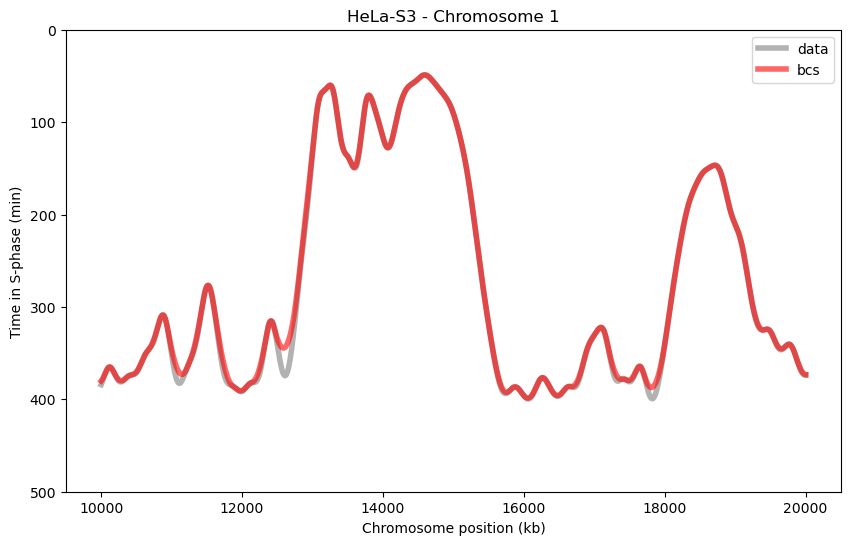

In [11]:
# Model parameters
# Pick cell line from ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
cell_line = "HeLa-S3"
chr_number = 1
chrpos_min = 10000
chrpos_max = 20000
fork_speed = 1.4
scale_factor = 5
resolution = 1000 # (1 kb)
file_name = cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)
saveQ = False # Saves the plot
spec_fileQ = False # Tweak between whole-genome data (preferred) or specific region fit

rt_plotf(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, scale_factor, resolution, file_name, spec_fileQ, saveQ)